In [ ]:
# Reference Code: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# Author: Shubajit Saha

In [2]:
import json

In [53]:
data_dumps = ['/home/shubajit/Documents/ML/Transliteration_BN-EN/bn_trans_18042020.json']

In [106]:
data = []
for f in data_dumps:
    with open(f,'r') as fip:
        data += fip.read().splitlines()
print(len(data))

250


In [123]:
from collections import defaultdict
data_dict = defaultdict(list)
for line in data:
    jdata = json.loads(line)
    for word in jdata['words']:
        normalized_word = word['en'].lower().strip()
        data_dict[word['bn']].append(normalized_word)

#Remove duplicates
for k,v in data_dict.items():
    data_dict[k] = list(set(v))

In [124]:
total_judgements = 0
cnt = 0
for k,v in data_dict.items():
    total_judgements += len(v)
print(len(data_dict),total_judgements)

3306 3328


## Build Vocabulary

In [128]:
def build_vocabulary(l,threshold=0.0,start_token='<SOS>',end_token='<EOS>',unk_token='<UNK>'):
    vocab = defaultdict(int)
    for line in l:
        for ch in line:
            vocab[ch] += 1
    vocab_list = []
    for k,v in vocab.items():
        vocab_list.append((k,v))
    vocab_list = sorted(vocab_list,key=lambda x:-1*x[1])
    return [start_token] + [end_token] + [x[0] for x in vocab_list if x[1] >= threshold] + [unk_token]

In [129]:
bengali_vocab = build_vocabulary(data_dict.keys(),30)
n_bengali_vocab = len(bengali_vocab)
print(n_bengali_vocab)

58


In [130]:
english_words = []
for k in data_dict:
    english_words += data_dict[k]
english_vocab = build_vocabulary(english_words,10)
n_english_vocab = len(english_vocab)
print(n_english_vocab)

41


## Train-Validation Split

In [140]:
n_train = int(len(data_dict)*0.8)
n_validation = len(data_dict) - n_train
print('#Train instances are: ',n_train)
print('#Validation instances are ',n_validation)

#Train instances are:  2644
#Validation instances are  662


In [156]:
def getDataSetFromKeys(key_list,data_dict):
    X = []
    y = []
    for key in key_list:
        for word in data_dict[key]:
            X.append(word)
            y.append(key)
    return X,y

In [158]:
import random

bn_words = list(data_dict.keys())
random.shuffle(bn_words)
bn_words_train = bn_words[:n_train]
bn_words_validation = bn_words[n_train:]

X_train,y_train = getDataSetFromKeys(bn_words_train,data_dict)
X_validation,y_validation = getDataSetFromKeys(bn_words_validation,data_dict)

print("Train Dataset size: ",len(X_train),len(y_train))
print("Validation Dataset size: ",len(X_validation),len(y_validation))
print(X_train[:10],y_train[:10])

Train Dataset size:  2662 2662
Validation Dataset size:  666 666
['shahriyar', 'broken', 'venge', 'porashona', 'jekkhetre', 'nepalio', 'duorani', 'peyechilam', 'to four', 'dagubati'] ['শাহরিয়ার', 'ভেঙ্গে', 'ভেঙ্গে', 'প়ড়াশোনা', 'যেক্ষেত্রে', 'নেপালিও', 'দুয়োরানী', 'পেয়েছিলাম', 'চারজনকে', 'দাগগুবাতি']


## Model Building

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Tensor Utilities

In [296]:
def charToIndex(ch,vocab_list,unk_token='<UNK>'):
    try:
        return vocab_list.index(ch)
    except ValueError:
        return vocab_list.index(unk_token)

def wordToTensor(word,vocab_list,start_token='<SOS>',end_token='<EOS>',unk_token='<UNK>'):
    indices = [charToIndex(ch,vocab_list,unk_token) for ch in word] + [charToIndex(end_token,vocab_list)]
    tensor = torch.tensor(indices,dtype=torch.long)
    return tensor

def pairToTensor(source,source_vocab,target,target_vocab):
    return wordToTensor(source,source_vocab),wordToTensor(target,target_vocab)

In [210]:
print(wordToTensor('tomar',english_vocab))
print(wordToTensor('আমরা',bengali_vocab))

tensor([ 8,  3, 16,  2,  4,  1])
tensor([33, 13,  3,  2,  1])


## Training Utilities

In [161]:
import time
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [279]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [270]:
def trainInstance(
        input_tensor,
        target_tensor,
        encoder,
        decoder,
        encoder_optimizer,
        decoder_optimizer,
        criterion,
        target_start_token,
        target_end_token,
        teacher_forcing_ratio = 0.0,
        max_length=25):
    
    #print("input: ",input_tensor.size(),input_tensor)
    #print("target: ",target_tensor.size(),target_tensor)
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        #print("Encoder output: ",encoder_output.size())
        #print("Encoder hidden: ",encoder_hidden.size())
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[target_start_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        #print("Using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        #print("Not using teacher forching.")
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, torch.tensor([target_tensor[di]]))
            if decoder_input.item() == target_end_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [274]:
def train(encoder,
          decoder,
          n_iters,
          learning_rate,
          dropout,
          X,
          y,
          target_start_token,
          target_end_token,
          teacher_forcing_ratio,
          max_length,
          print_every=100,
          plot_every=100):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    indices = [random.randint(0,len(X)-1) for _ in range(n_iters)]
    training_pairs = [(X[id],y[id])
                      for id in indices]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = trainInstance(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion,target_start_token,target_end_token,teacher_forcing_ratio,max_length)
        
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    return plot_losses

In [328]:
def evaluateInstance(source,encoder,decoder,start_token, end_token, source_vocab, target_vocab,max_length=25):
    with torch.no_grad():
        input_tensor = wordToTensor(source,source_vocab)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
        print(encoder_hidden)
        decoder_input = torch.tensor([[start_token]])  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            print(decoder_output.size(),decoder_hidden.size())
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == end_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(target_vocab[topi.item()])
                
            decoder_input = topi.squeeze().detach()
            
        return decoded_words

In [ ]:
def evaluate(encoder,decoder,X,y,start_token,end_token,course_vocab,target_vocab,)

## Model

### Encode-Decoder with GRU

In [234]:
class Encoder(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(Encoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        
    def forward(self,input,hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output,hidden = self.gru(output,hidden)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [239]:
class Decoder(nn.Module):
    def __init__(self,output_size,hidden_size):
        super(Decoder,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size,hidden_size)
        self.gru = nn.GRU(hidden_size,hidden_size)
        self.out = nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = F.relu(embedded)
        output,hidden = self.gru(output,hidden)
        output = self.softmax(self.out(output[0]))
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

### Experiment-1
### Details: 
Moderl: Encoder Decoder
Architecture: Single layer GRU 128 dimension

In [294]:
## Parameters:
learning_rate = 5*1e-2
n_iters = 5000
dropout = 0.5
teacher_forcing_ratio = 0.0
max_length = 25
input_dim = n_english_vocab
output_dim = n_bengali_vocab
hidden_dim = 256
encoder = Encoder(input_dim,hidden_dim)
decoder = Decoder(output_dim,hidden_dim)

0m 3s (- 2m 43s) (100 2%) 2.3090
0m 6s (- 2m 34s) (200 4%) 2.2179
0m 9s (- 2m 33s) (300 6%) 2.0844
0m 13s (- 2m 31s) (400 8%) 2.1566
0m 16s (- 2m 30s) (500 10%) 2.0929
0m 20s (- 2m 26s) (600 12%) 2.0889
0m 23s (- 2m 23s) (700 14%) 2.2575
0m 26s (- 2m 19s) (800 16%) 2.1602
0m 29s (- 2m 16s) (900 18%) 2.0709
0m 33s (- 2m 13s) (1000 20%) 2.1234
0m 36s (- 2m 9s) (1100 22%) 2.0253
0m 39s (- 2m 6s) (1200 24%) 2.1424
0m 43s (- 2m 3s) (1300 26%) 2.1872
0m 46s (- 1m 59s) (1400 28%) 2.0301
0m 49s (- 1m 56s) (1500 30%) 2.1368
0m 53s (- 1m 52s) (1600 32%) 2.0594
0m 56s (- 1m 49s) (1700 34%) 2.0574
0m 59s (- 1m 46s) (1800 36%) 2.0946
1m 3s (- 1m 42s) (1900 38%) 2.0278
1m 6s (- 1m 39s) (2000 40%) 2.2293
1m 9s (- 1m 36s) (2100 42%) 2.0866
1m 12s (- 1m 32s) (2200 44%) 1.9948
1m 16s (- 1m 29s) (2300 46%) 2.0512
1m 19s (- 1m 26s) (2400 48%) 2.0051
1m 22s (- 1m 22s) (2500 50%) 2.1741
1m 25s (- 1m 19s) (2600 52%) 2.0297
1m 29s (- 1m 16s) (2700 54%) 2.0898
1m 32s (- 1m 12s) (2800 56%) 2.0265
1m 35s (- 1m 9

<Figure size 432x288 with 0 Axes>

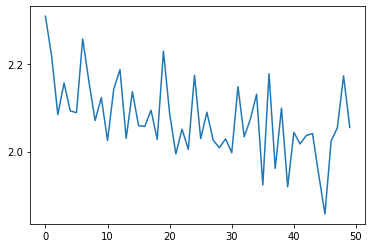

In [307]:
## Training English to Bengali Transliteration
X_train_tensor = [wordToTensor(word,english_vocab) for word in  X_train]
y_train_tensor = [wordToTensor(word,bengali_vocab) for word in  y_train]
plot_losses = train(encoder,decoder,n_iters,learning_rate,dropout,X_train_tensor,y_train_tensor,bengali_vocab.index('<SOS>'),bengali_vocab.index('<EOS>'),teacher_forcing_ratio,max_length)
showPlot(plot_losses)

In [300]:
X_validation_tensor = [wordToTensor(word,english_vocab) for word in  X_validation]
y_validation_tensor = [wordToTensor(word,bengali_vocab) for word in  y_validation]

In [325]:
id = random.randint(0,len(X_validation_tensor)-1)

In [329]:
print(X_validation[id],y_validation[id],X_validation_tensor[id])
evaluateInstance(X_validation_tensor[id],encoder,decoder,bengali_vocab.index('<SOS>'),bengali_vocab.index('<EOS>'),english_vocab,bengali_vocab,max_length=60)

babad বাবাদ tensor([13,  2, 13,  2, 12,  1])
tensor([[[ 0.0153,  0.0215, -0.4463,  0.4836,  0.2189,  0.0711,  0.2445,
           0.7045,  0.5012, -0.1321, -0.7384, -0.2245, -0.2357, -0.0730,
           0.5046, -0.0864, -0.1356,  0.7219, -0.1491,  0.6414,  0.2135,
          -0.4842, -0.2177, -0.0055, -0.1867, -0.1841, -0.4529, -0.4513,
          -0.3016,  0.3933,  0.1484,  0.2030,  0.2970, -0.3727, -0.2631,
           0.5929, -0.0492,  0.4421,  0.6103, -0.2370, -0.0553,  0.1398,
          -0.0320, -0.1375,  0.0447, -0.2594, -0.4499, -0.3194,  0.2962,
          -0.0036,  0.0446,  0.1331,  0.4626, -0.2390,  0.0533, -0.1584,
          -0.6295, -0.3477,  0.2136, -0.0722,  0.4934, -0.0533,  0.3930,
          -0.7778, -0.1588,  0.0504, -0.3833, -0.4652,  0.5963,  0.0543,
           0.2107, -0.4085, -0.3674, -0.0726,  0.6808,  0.2076,  0.0443,
          -0.5830,  0.1653,  0.6095, -0.5143,  0.1276,  0.7111,  0.0845,
          -0.2186, -0.3620, -0.3148, -0.4942,  0.2884, -0.4627,  0.6003,
      

['ঘ',
 'ড',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—',
 '—']